In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Path to save the model and logs
model_path = '/content/drive/My Drive/Colab Notebooks/contentfilter/InceptionV3_best_model.h5'
log_path = '/content/drive/My Drive/Colab Notebooks/contentfilter/InceptionV3_training_log.csv'

# Setup ModelCheckpoint to save the model with the best validation accuracy
model_checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1)

# Setup CSVLogger to save the training data
csv_logger = CSVLogger(log_path, append=True)


In [4]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K  # Import keras.backend as K

def get_f1_score(precision, recall):
    def f1_score(y_true, y_pred):
        p = precision(y_true, y_pred)
        r = recall(y_true, y_pred)
        return 2 * ((p * r) / (p + r + K.epsilon()))
    return f1_score

# Instantiate Precision and Recall metrics
precision_metric = Precision()
recall_metric = Recall()

# Create a custom F1 Score metric
f1_score_metric = get_f1_score(precision_metric, recall_metric)

In [5]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load CIFAR-10 data
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values and resize images for Inception V3
train_images = tf.image.resize(train_images, [75, 75]).numpy()  # Resize images
test_images = tf.image.resize(test_images, [75, 75]).numpy()

train_images = preprocess_input(train_images)  # Preprocess for Inception V3
test_images = preprocess_input(test_images)

# Convert labels to categorical
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

170498071/170498071 [==============================] - 2s 0us/step


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object for augmenting training data
train_datagen = ImageDataGenerator(
    rotation_range=40,       # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,   # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,         # Randomly apply shearing transformations
    zoom_range=0.2,          # Randomly zoom into images
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill in new pixels in case of zoom or rotation
)

# No augmentation for the validation data, only rescaling
test_datagen = ImageDataGenerator()


In [7]:
# Prepare generators for training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
validation_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

In [8]:
# Load the InceptionV3 model without the top layer to add a custom classifier
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
base_model.trainable = False  # Freeze the convolutional base

# Create a new top layer that matches the number of CIFAR-10 classes
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Add these metrics to your model compilation step
# Compile the model with custom defined metrics
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision_metric, recall_metric, f1_score_metric])

87910968/87910968 [==============================] - 1s 0us/step


In [9]:
# Train the model using the data augmentation generators
# model.fit(train_generator,
#           epochs=30,
#           validation_data=validation_generator)
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    callbacks=[model_checkpoint, csv_logger])

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 1.3846 - accuracy: 0.5137 - precision_1: 0.6778 - recall_1: 0.3380 - f1_score: 0.3929
Epoch 1: val_accuracy improved from -inf to 0.58720, saving model to /content/drive/My Drive/Colab Notebooks/contentfilter/InceptionV3_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1563/1563 [==============================] - 131s 78ms/step - loss: 1.3846 - accuracy: 0.5137 - precision_1: 0.6778 - recall_1: 0.3380 - f1_score: 0.3929 - val_loss: 1.1659 - val_accuracy: 0.5872 - val_precision_1: 0.7446 - val_recall_1: 0.4239 - val_f1_score: 0.5424
Epoch 2/30
1563/1563 [==============================] - ETA: 0s - loss: 1.2459 - accuracy: 0.5598 - precision_1: 0.7075 - recall_1: 0.3979 - f1_score: 0.5061
Epoch 2: val_accuracy improved from 0.58720 to 0.62030, saving model to /content/drive/My Drive/Colab Notebooks/contentfilter/InceptionV3_best_model.h5
1563/1563 [==============================] - 120s 77ms/step - loss: 1.2459 - accuracy: 0.5598 - precision_1: 0.7075 - recall_1: 0.3979 - f1_score: 0.5061 - val_loss: 1.0808 - val_accuracy: 0.6203 - val_precision_1: 0.7605 - val_recall_1: 0.4730 - val_f1_score: 0.5815
Epoch 3/30
1563/1563 [==============================] - ETA: 0s - loss: 1.2132 - accuracy: 0.5714 - precision_1: 0.7168 - recall_1: 0.4175 - f1_score: 0.5

In [10]:
import pandas as pd

# Define the path to the CSV file
log_path = '/content/drive/My Drive/Colab Notebooks/contentfilter/InceptionV3_training_log.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(log_path)


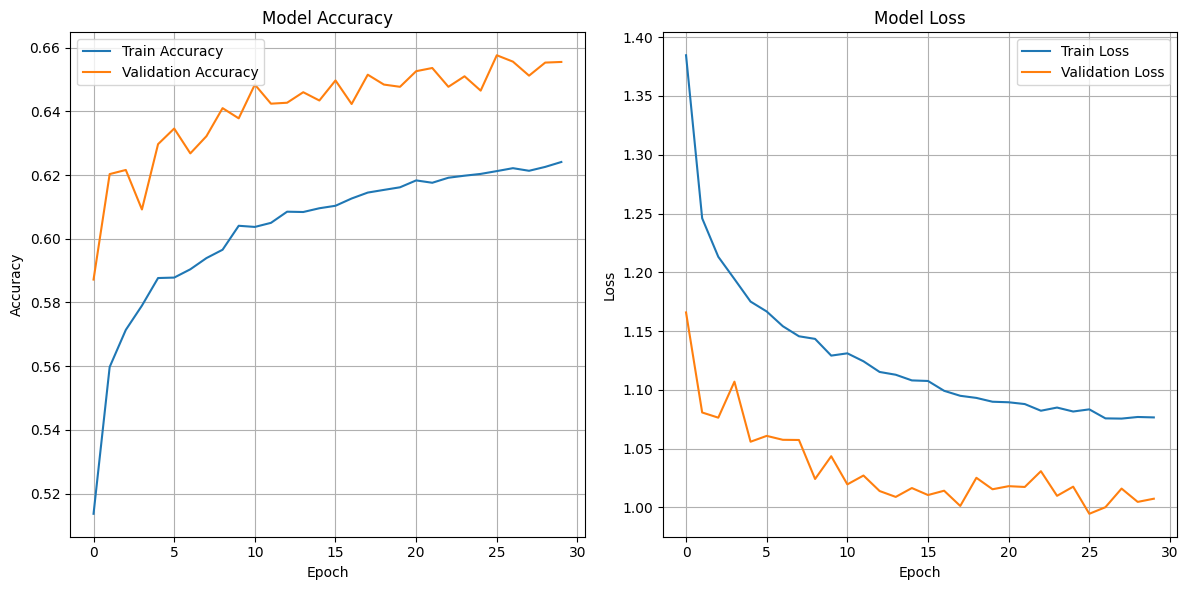

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='Train Accuracy')
plt.plot(df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)  # Enable grid

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='Train Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)  # Enable grid

plt.tight_layout()
plt.show()


In [12]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    precision = Precision()(y_true, y_pred)
    recall = Recall()(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [13]:
from tensorflow.keras.models import load_model

# Define the path to the saved model
model_path = '/content/drive/My Drive/Colab Notebooks/contentfilter/InceptionV3_best_model.h5'

# Load the model with custom objects
model = load_model(model_path, custom_objects={'f1_score': f1_score})


In [14]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

313/313 [==============================] - 5s 13ms/step


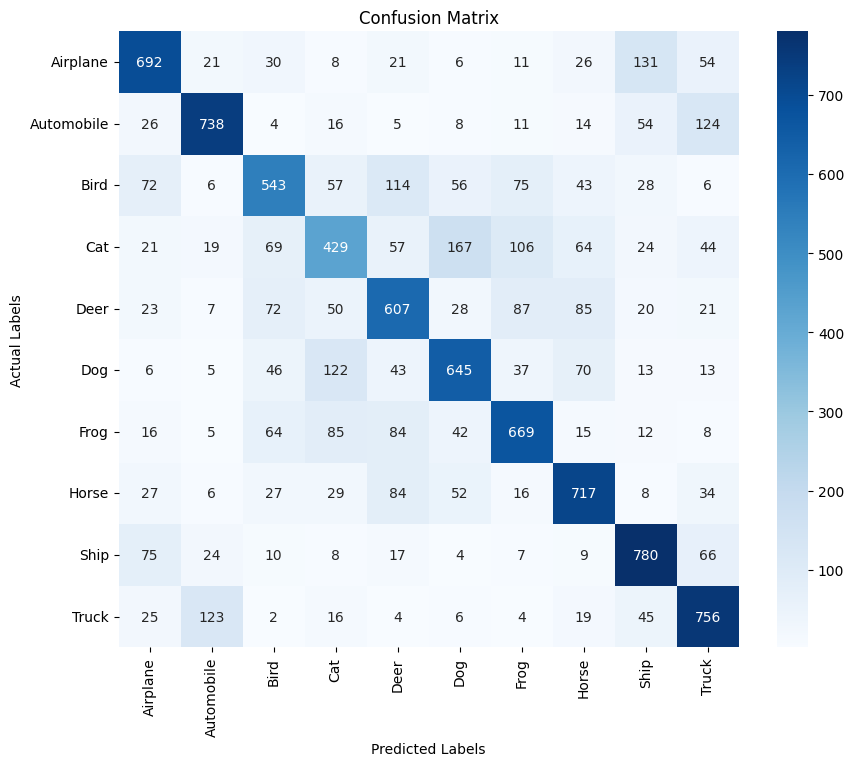

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have test_images and test_labels, and a trained model named 'model'
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(test_true_classes, test_predictions_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()



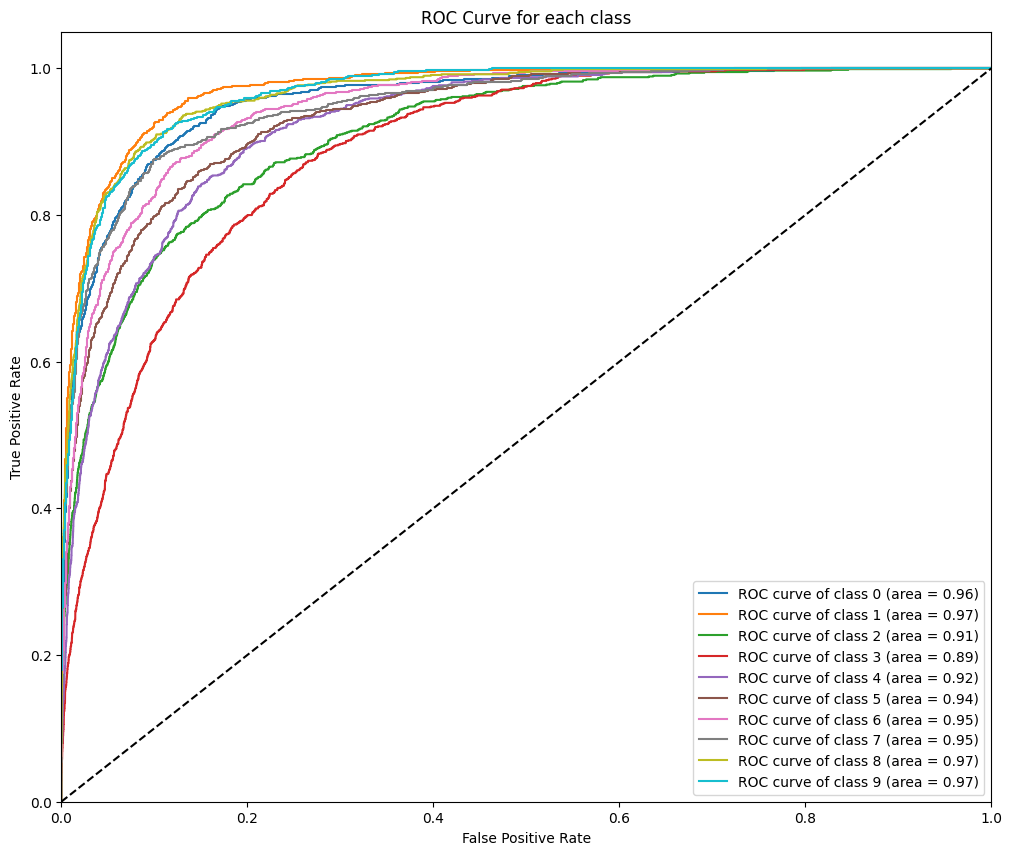

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC curve
test_labels_binarized = label_binarize(test_true_classes, classes=np.arange(10))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 10))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()


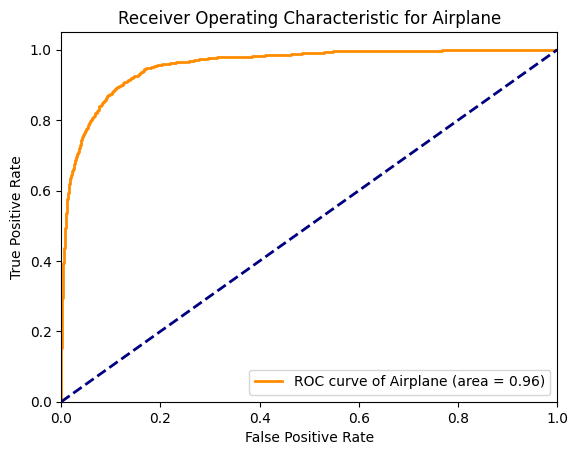

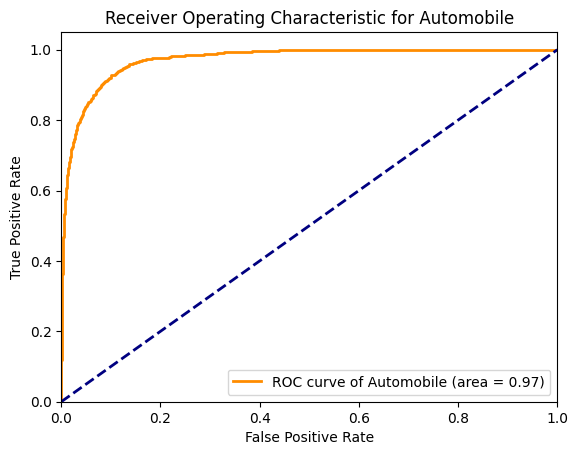

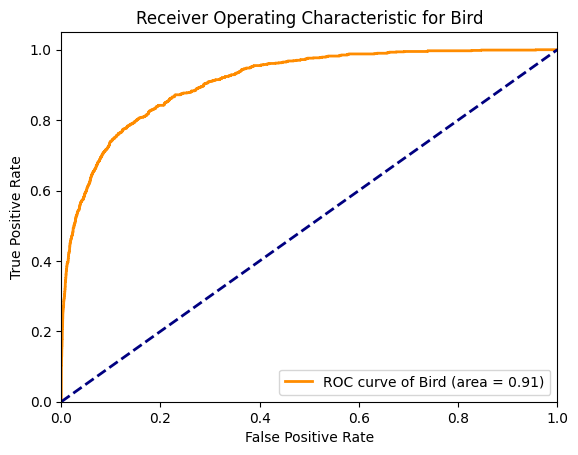

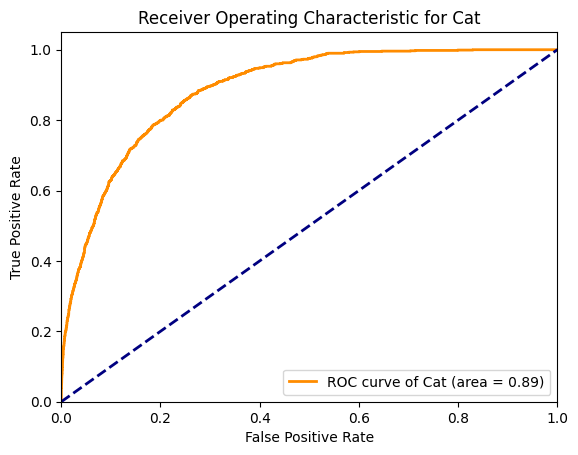

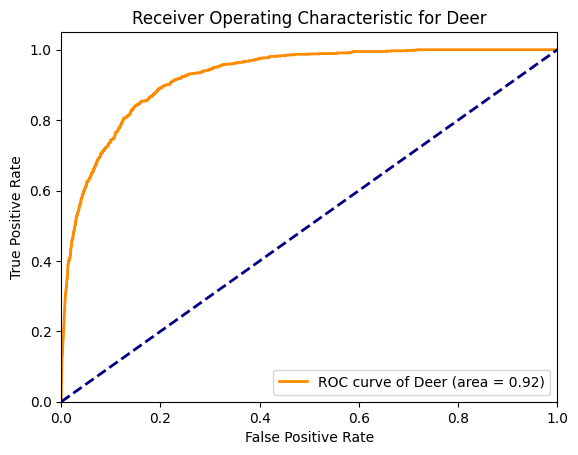

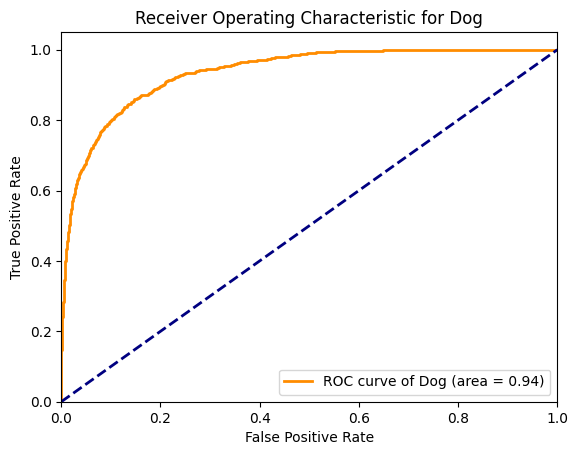

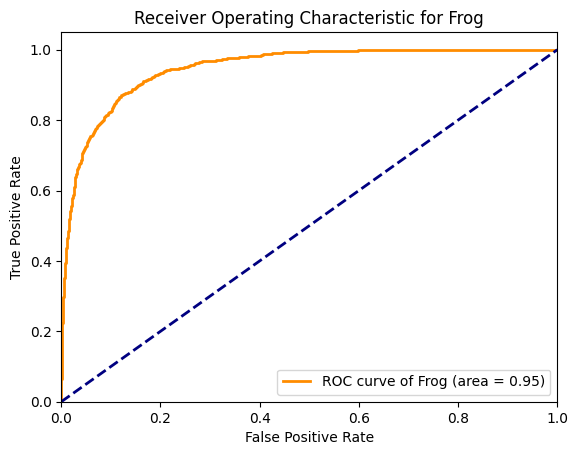

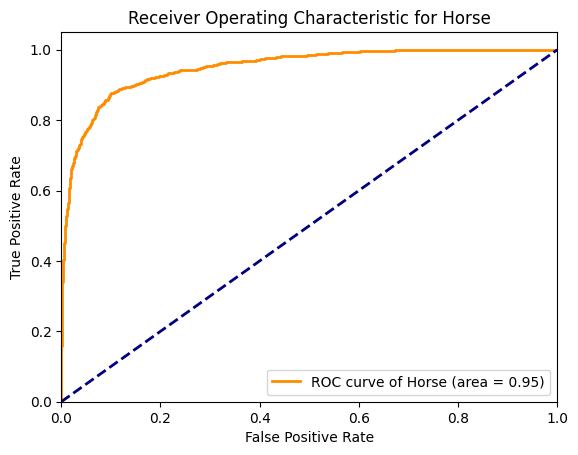

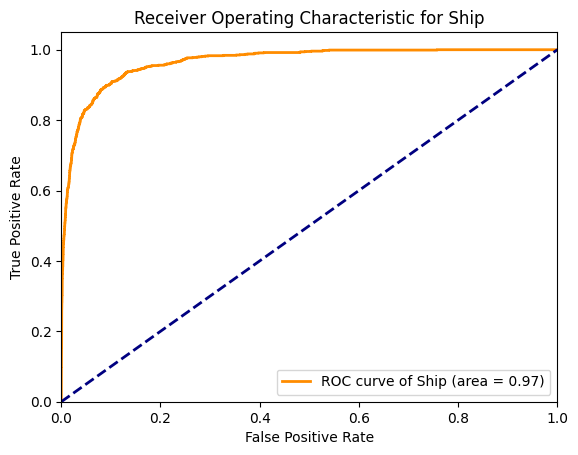

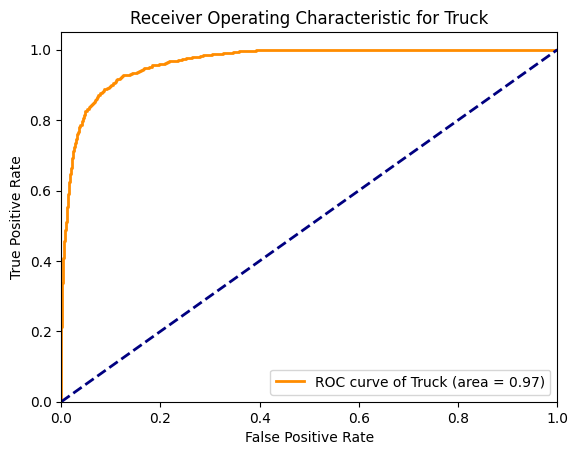

In [17]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming test_labels and test_predictions are defined and that test_labels are one-hot encoded

# Prepare ROC curve data
fpr = {}
tpr = {}
roc_auc = {}
for i in range(10):  # CIFAR-10 has 10 classes
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
for i in range(10):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {class_names[i]}')
    plt.legend(loc="lower right")
    plt.show()


In [18]:
df

,epoch,accuracy,f1_score,loss,precision_1,recall_1,val_accuracy,val_f1_score,val_loss,val_precision_1,val_recall_1
0,0,0.51368,0.392930,1.384602,0.677762,0.33800,0.5872,0.542364,1.165853,0.744599,0.4239
1,1,0.55976,0.506103,1.245922,0.707504,0.39790,0.6203,0.581516,1.080751,0.760450,0.4730
2,2,0.57140,0.525114,1.213162,0.716773,0.41752,0.6216,0.572141,1.076342,0.773514,0.4556
3,3,0.57902,0.531618,1.194249,0.720332,0.42720,0.6092,0.581684,1.106964,0.733629,0.4795
4,4,0.58768,0.548990,1.175069,0.723810,0.44012,0.6297,0.594443,1.055884,0.759393,0.4952
5,5,0.58782,0.548874,1.166667,0.724712,0.44048,0.6346,0.600292,1.060851,0.764119,0.4979
6,6,0.59042,0.555721,1.154140,0.727697,0.44912,0.6268,0.604156,1.057515,0.753660,0.5045
7,7,0.59394,0.566164,1.145569,0.731753,0.45496,0.6322,0.612506,1.057359,0.750840,0.5138
8,8,0.59656,0.557484,1.143351,0.730660,0.45656,0.6410,0.615820,1.024184,0.772063,0.5179
9,9,0.60408,0.572370,1.129125,0.737128,0.46386,0.6378,0.607028,1.043540,0.759065,0.5129


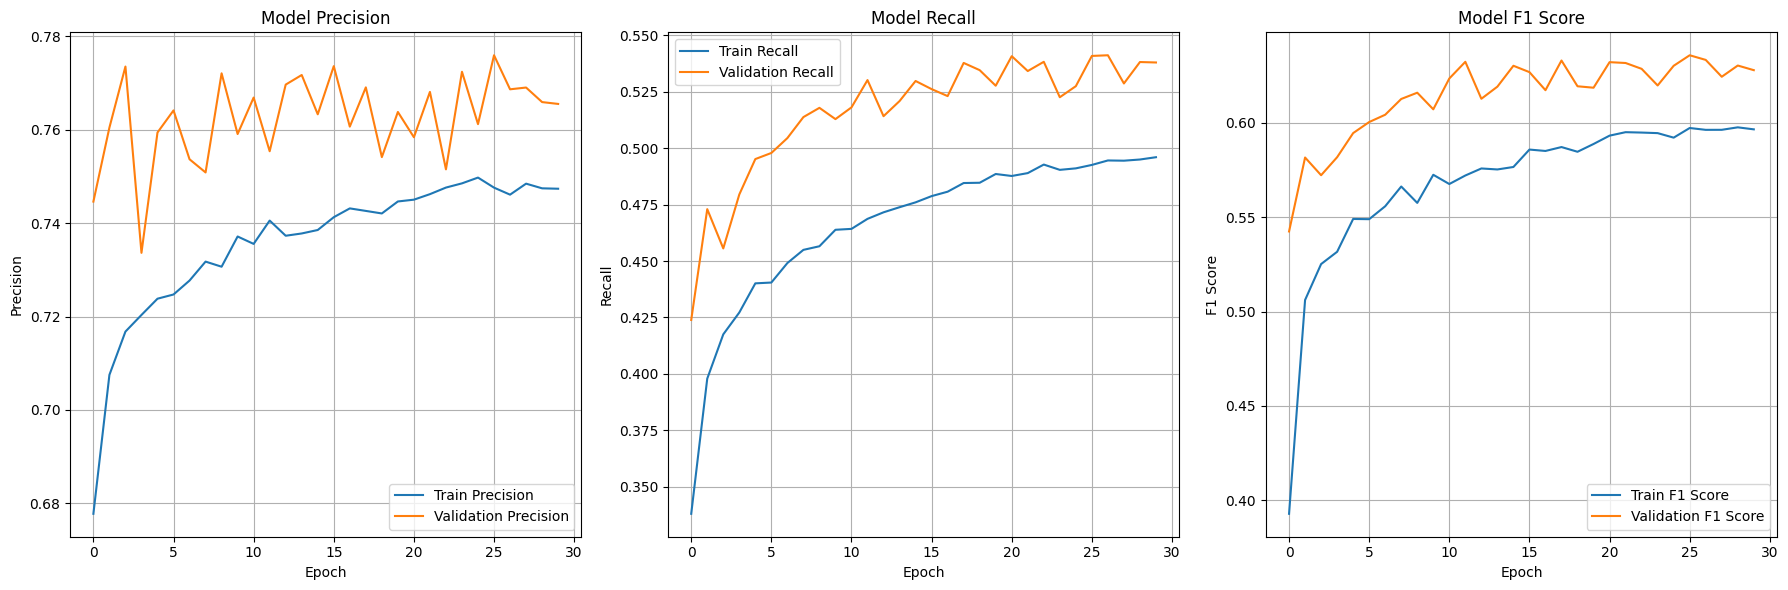

In [23]:
# Plot Precision, Recall, and F1-score
plt.figure(figsize=(18, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.plot(df['precision_1'], label='Train Precision')
plt.plot(df['val_precision_1'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.grid(True)

# Plot Recall
plt.subplot(1, 3, 2)
plt.plot(df['recall_1'], label='Train Recall')
plt.plot(df['val_recall_1'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.grid(True)

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.plot(df['f1_score'], label='Train F1 Score')
plt.plot(df['val_f1_score'], label='Validation F1 Score')
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()


In [24]:
# Predict classes with the maximum probability
predicted_classes = np.argmax(model.predict(test_images), axis=1)
true_classes = np.argmax(test_labels, axis=1)


313/313 [==============================] - 4s 13ms/step


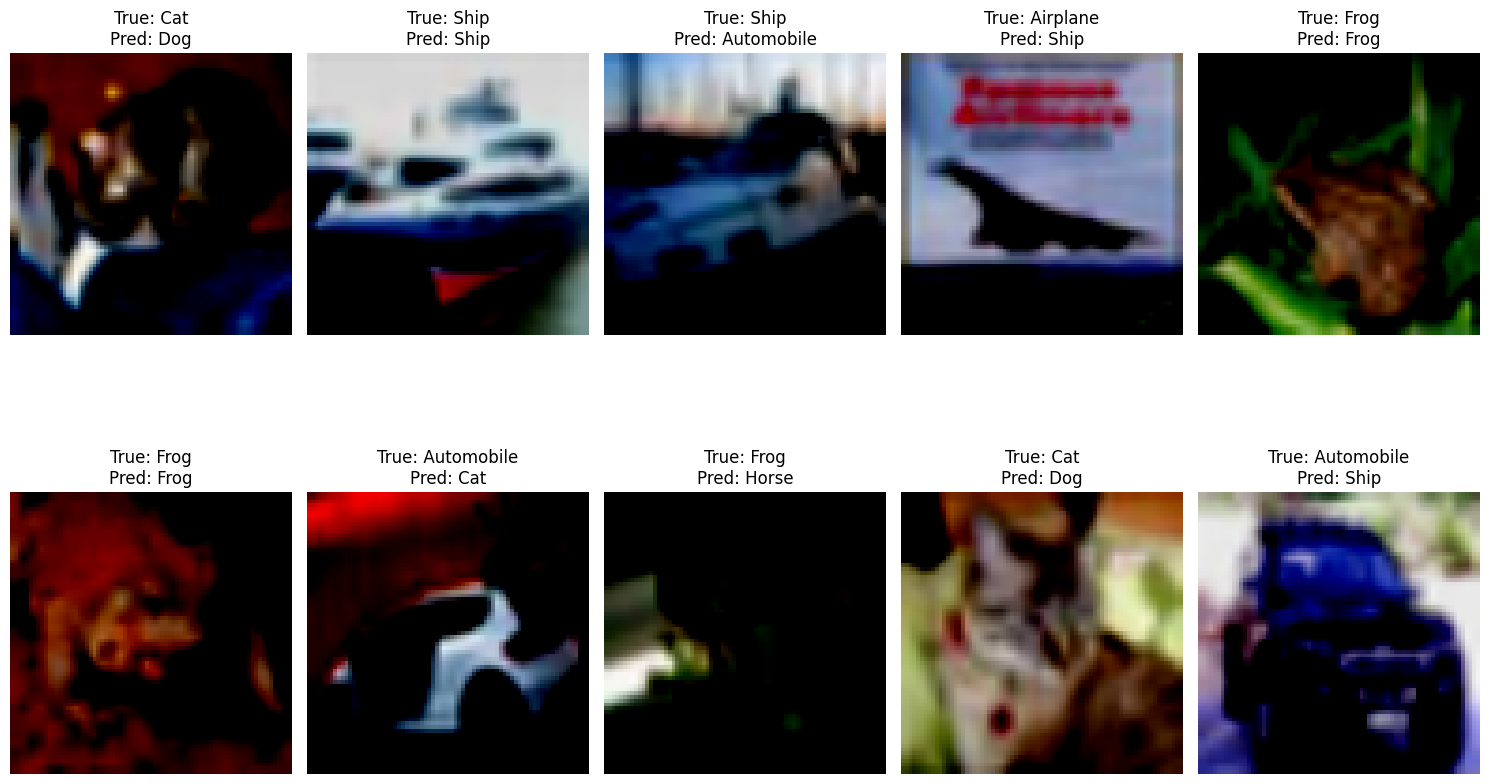

In [25]:
import matplotlib.pyplot as plt

# Function to plot images and their labels
def plot_images(images, true_labels, pred_labels, class_names):
    plt.figure(figsize=(15, 10))
    for i in range(10):  # plot 10 images
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assume test_images are already preprocessed if needed (e.g., scaling)
# If preprocessing was used (like normalization), you may need to adjust the images to display correctly:
# example: images_to_show = test_images * 255 if images were normalized to [0, 1] range during preprocessing
images_to_show = test_images[:10]  # Select the first 10 images
true_labels = true_classes[:10]   # Select the first 10 true labels
predicted_labels = predicted_classes[:10]  # Select the first 10 predicted labels

plot_images(images_to_show, true_labels, predicted_labels, class_names)
